In [33]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

I will mostly be using this notebook for my capstone project with Coursera

I will peridoically update it

# Hello Capstone Project Course!

## Introduction

I am going to be trying to help both businesses and individuals who are interested in social, outdoor activities.  People in this category may want to know how many parks are close to a given neighborhood since this will give more opportunities for outdoor social activities.  Businesses may want to know what neighborhoods are lacking these amenities since it may indicate areas of the market that are under-served, and they could offer alternatives to parks (such as golf courses).  If, for example, a business is considering building a golf course, they will need to know if there are other golf courses in the area they will need to compete against, and they will need to know how many parks are available which may be (economically speaking) a substitute for golf courses.  On the other hand, parks may be a compliment to golf courses, either way, it is vitally impr=ortant for businesses to know information about parks and golf courses in the area.



## Data

I will be leveraging four-square data to group neighborhoods in Toronto based on the number of parks within a given radius, number of golf courses within the same radius, and the average distance of those parks and golf courses (this will indicate whether the parks and golf courses are near the center or concentrated on the edges of the circle).

## Methodology

I have saved the data about neighborhoods from the scraping and cleaning into a csv file, and I load it in the following cell (see initial_scrape_cluster.ipynb)

In [7]:
df=pd.read_csv('lat_lon_ata.csv')

In [8]:
df.head()


,Unnamed: 0,Postcode,Borough,Neighbourhood,Lat,Long
0,0,M3A,North York,Parkwoods,43.753259,-79.329656
1,1,M4A,North York,Victoria Village,43.725882,-79.315572
2,2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,4,M6A,North York,Lawrence Heights,43.718518,-79.464763


I have saved my foursquare credentials into an external text file, I load those credentials in the following cell (the file is not included)

In [11]:
with open('credentials.txt') as creds:
    lines=creds.readlines()
    
for i in range(len(lines)):
    lines[i]=lines[i].strip('\n')

In [12]:
CLIENT_ID,CLIENT_SECRET,VERSION,LIMIT=lines

We will search for Parks and Golf courses on four square

In [13]:
search_query = 'Park Golf'
radius = 1000

In [14]:
urls=[]
for i in list(df.index):
    lat,long=list(df.iloc[i].values[-2:])
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, search_query, radius, LIMIT)
    urls.append(url)

The following two cells use code given in the Four Square API tutorial, I modified it slightly to better suit this project, but it is largely identical.

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
dfs_all=[]
features=[]
for i in urls:
    results=requests.get(i).json()
    try:
        venues = results['response']['venues']
        res_df = json_normalize(venues)
        filtered_columns = ['name', 'categories'] + [col for col in res_df.columns if col.startswith('location.')] + ['id']
        dataframe_filtered = res_df.loc[:, filtered_columns]
        dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
        dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
        dataframe_filtered_p=dataframe_filtered[dataframe_filtered['categories']=='Park']
        dataframe_filtered_g=dataframe_filtered[dataframe_filtered['categories']=='Golf Course']
        dfs_all.append(dataframe_filtered)
        #create features based on the number of parks, golf courses, and the distance of each
        feat=[len(list(dataframe_filtered_p.index)),
                         dataframe_filtered_p['distance'].mean(),
                         len(list(dataframe_filtered_g.index)),
                         dataframe_filtered_g['distance'].mean()]
        for i in range(2):
            if feat[2*i]==0:
                feat[2*i+1]=0
        features.append(feat)
    #If there is nothing close by, we set the features to zero, this will make it so that Kmeans will cluster the
    #Neighborhoods without ammenities close by together, which is what we want
    except KeyError:
        features.append([0,
                         0,
                         0,
                         0])
    
    
    

In [23]:
features[:5]

[[7, 761.8571428571429, 2, 942.5],
 [4, 1003.0, 1, 978.0],
 [11, 738.2727272727273, 0, 0],
 [11, 738.2727272727273, 0, 0],
 [3, 823.0, 0, 0]]

In [26]:
features_df=pd.DataFrame(features)
features_df.columns=['Park Count','Park Distance','Golf Count','Golf Distance']

In [27]:
features_df.head()

,Park Count,Park Distance,Golf Count,Golf Distance
0,7,761.857143,2,942.5
1,4,1003.000000,1,978.0
2,11,738.272727,0,0.0
3,11,738.272727,0,0.0
4,3,823.000000,0,0.0


In [45]:
norm_features=normalize(features_df,axis=0)

In [46]:
clusters=KMeans(n_clusters=5, random_state=0).fit(norm_features)

In this sectioni we plot the groups we found based on nearby parks and golf courses.  In the following visualization we are still looking at location, and since we are not grouping on location we may not see any obvious clustering; however we can see some patterns.

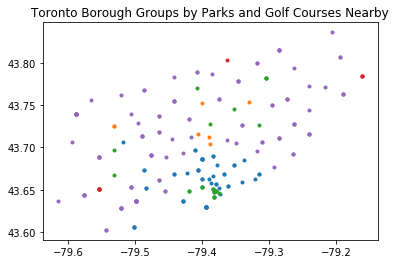

In [48]:
for i in range(5):
    points=df[['Lat','Long']][clusters.labels_==i]
    plt.plot(points['Long'],points['Lat'],'.')
plt.title('Toronto Borough Groups by Parks and Golf Courses Nearby')
plt.show()

In the following Visualization we plot the normalized number of parks against the normalized average distance, we can see some clustering here, but it's still not perfect since we can only see two of the four features we are clustering on.

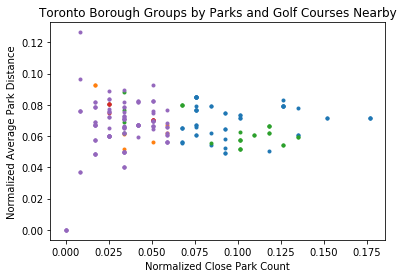

In [52]:
for i in range(5):
    points=norm_features[:,:2][clusters.labels_==i]
    plt.plot(points[:,0],points[:,1],'.')
plt.title('Toronto Borough Groups by Parks and Golf Courses Nearby')
plt.xlabel('Normalized Close Park Count')
plt.ylabel('Normalized Average Park Distance')
plt.show()

Now in this Visualization we really can see how the groups were clustered.  The Green group has a medium number of close golf courses, but is far away on average, the red has about the same number of golf courses nearby compared to green, but the red group is closer to the golf courses on average. The orange has many golf courses nearby, but is farther away on average than the red. Last of all the purple has no golf courses nearby.

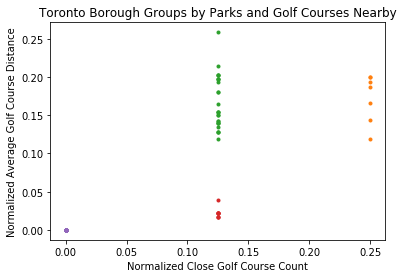

In [53]:
for i in range(5):
    points=norm_features[:,2:][clusters.labels_==i]
    plt.plot(points[:,0],points[:,1],'.')
plt.title('Toronto Borough Groups by Parks and Golf Courses Nearby')
plt.xlabel('Normalized Close Golf Course Count')
plt.ylabel('Normalized Average Golf Course Distance')
plt.show()

After looking at the data, it seems like golf courses are almost entirely defining the groups, so I will give greater weight to parks, and see if I can get a better balance.

In [54]:
norm_features[:5]

array([[0.05892974, 0.0668968 , 0.25      , 0.18694681],
       [0.03367414, 0.08807096, 0.125     , 0.1939883 ],
       [0.09260388, 0.06482591, 0.        , 0.        ],
       [0.09260388, 0.06482591, 0.        , 0.        ],
       [0.0252556 , 0.0722656 , 0.        , 0.        ]])

In [76]:
weighted_norm_features=np.copy(norm_features)
weighted_norm_features[:,:2]*=2
weighted_norm_features[:5]

array([[0.11785948, 0.1337936 , 0.25      , 0.18694681],
       [0.06734828, 0.17614192, 0.125     , 0.1939883 ],
       [0.18520776, 0.12965182, 0.        , 0.        ],
       [0.18520776, 0.12965182, 0.        , 0.        ],
       [0.05051121, 0.1445312 , 0.        , 0.        ]])

In [77]:
w_clusters=KMeans(n_clusters=5, random_state=0).fit(weighted_norm_features)

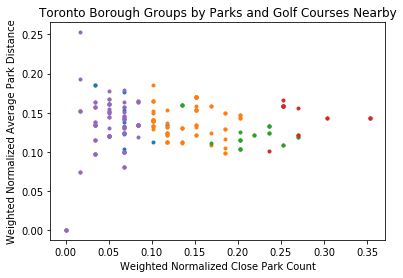

In [78]:
for i in range(5):
    points=weighted_norm_features[:,:2][w_clusters.labels_==i]
    plt.plot(points[:,0],points[:,1],'.')
plt.title('Toronto Borough Groups by Parks and Golf Courses Nearby')
plt.xlabel('Weighted Normalized Close Park Count')
plt.ylabel('Weighted Normalized Average Park Distance')
plt.show()

Now the Groups seem to depend much more on both the parks and golf courses and not only the golf courses. 

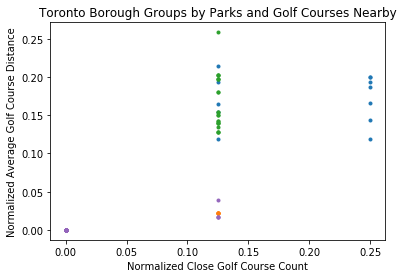

In [80]:
for i in range(5):
    points=weighted_norm_features[:,2:][w_clusters.labels_==i]
    plt.plot(points[:,0],points[:,1],'.')
plt.title('Toronto Borough Groups by Parks and Golf Courses Nearby')
plt.xlabel('Normalized Close Golf Course Count')
plt.ylabel('Normalized Average Golf Course Distance')
plt.show()

Now we will plot average distance from golf courses and parks so that we can see a graph where both variables are continuous

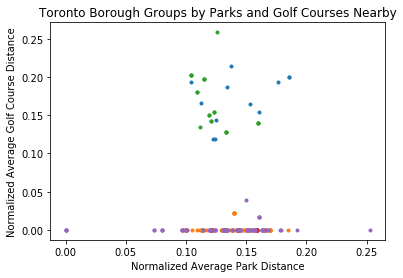

In [82]:
for i in range(5):
    points=weighted_norm_features[:,[1,3]][w_clusters.labels_==i]
    plt.plot(points[:,0],points[:,1],'.')
plt.title('Toronto Borough Groups by Parks and Golf Courses Nearby')
plt.xlabel('Normalized Average Park Distance')
plt.ylabel('Normalized Average Golf Course Distance')
plt.show()

From the Above plot, we can see that Purple and orange groups have few or no golf courses nearby, and from previous plots we know that thse groups also don't have as many parks, so businesses offering more options in outdoor social activities may find these areas to be a good area to expand into since there isn't as much competition.

## Discussion

Based on the results of our clustering, we can clearly see that there are groups which are underserved.  The purple and orange groups are far away from golf courses, so these are good candidates for building a golf course.  In particular, the purple has very few golf courses, and very few parks, thus these neighborhoods can take some serious consideration.  If an individual is using this data to find what neighborhoods are desirable to live in, the green group seems to have a good combination of parks and golf courses.

## Conclusion

The results seem to indicate the possibility of investment opportunities for businesses, but the results are only indicators.  More analysis may be necessary before a choice is made.  For example, some of the neighborhoods may on average attract individuals who are not looking for outdoor social activities.  If this is the case, the lack of outdoor ammenities in certain areas may be indicative of a lack of demand for these services, and not a lack of service.  In any case, these results provide a valuable starting point for further research.